# Exponential vs retraction updates for Frechet mean optimisation

We measure the time taken to arrive within a neighbourhood of the solution to the Frechet mean optimisation for updates made using the exponential map in hyperbolic space vs using its retraction (i.e. first-order linear approximation on the Poincare disc).  The optimisation problem is, for $N$ points:

$$ E (\theta) = 0.5 / N \sum_i d^2 (x^{(i)}, \theta)$$

for $\theta, x^{(i)}$ in hyperbolic space.

In order to measure this, we need to be able to sample uniformly - code for this is included as well.

In [1]:
import numpy as np
from manifold import *
from plotting import *
import matplotlib.pyplot as plt

# Uniform random sampling code

In [2]:
def uniform_sample_hyperboloid_disc(max_distance, centre=None):
    """
    Return a sample drawn uniformly at random from the disc of
    radius `max_distance` on the hyperboloid.
    NOTE: formula is specific to the case of local-dimension 2.
    """
    rank = 2
    tangent = np.random.randn(rank + 1)
    tangent[rank] = 0
    tangent /= np.sqrt(tangent.dot(tangent))
    # we use inversion sampling: invert the CDF, apply result to uniform random samples from [0,1]
    p = np.random.uniform()
    tangent *= np.arccosh(1 + p * (np.cosh(max_distance) - 1))
    basept = coordinate_vector(rank, rank + 1)
    if centre is None:
        centre = basept
    else:
        centre_log = logarithm(basept, centre)
        tangent = geodesic_parallel_transport(basept, centre_log, tangent)
    return exponential(centre, tangent)

### Example

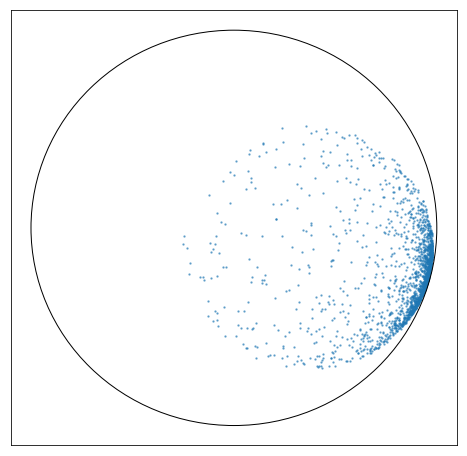

In [3]:
fig, ax = plot_disc()
centrept = uniform_sample_hyperboloid_disc(3)
ppoints = np.array([to_poincare_ball_point(uniform_sample_hyperboloid_disc(3, centrept)) for _ in range(2000)])
ax.scatter(ppoints[:,0], ppoints[:,1], alpha=0.5, s=2)
plt.show()

# Optimisation code

### Used for finding the point we are trying to converge to:

In [4]:
def frechet_mean(points, MIN_GRAD_NORM=1e-12):
    """
    Given a 2d numpy array of points on the hyperboloid, keep making updates
    until the gradient norm falls below MIN_GRAD_NORM; re-inits if necessary.
    """
    lr = 0.05
    theta = uniform_sample_hyperboloid_disc(1)
    steps = 1
    while True:
        hyperboloid_gradient = frechet_gradient(theta, points)
        gradient_norm = np.sqrt(minkowski_dot(hyperboloid_gradient, hyperboloid_gradient))
        if (gradient_norm < MIN_GRAD_NORM):
            break
        theta = exponential(theta, -1 * lr * hyperboloid_gradient)
        steps += 1
        if steps % 1000 == 0:
            theta = uniform_sample_hyperboloid_disc(1)
            print('re-init to find solution')
    return theta

# Illustration of the problem

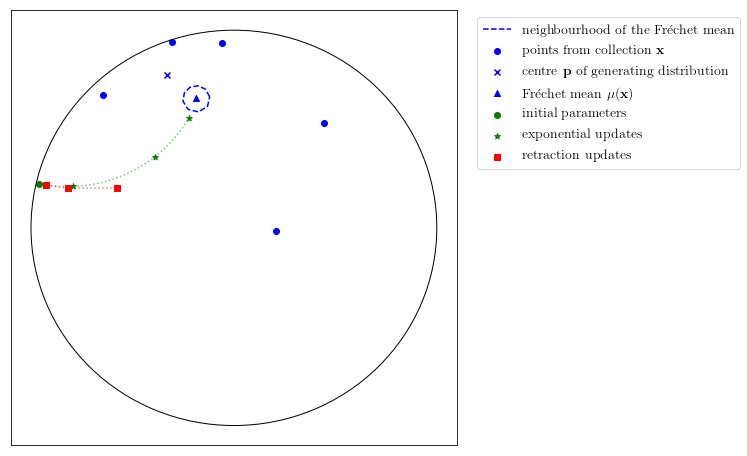

In [5]:
def illustrate(radius, number_points, tolerance, lr, number_of_steps):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    centrept = uniform_sample_hyperboloid_disc(radius)
    points = np.array([uniform_sample_hyperboloid_disc(radius, centre=centrept) for _ in range(number_points)])
    target = frechet_mean(points)
    init = uniform_sample_hyperboloid_disc(2 * radius)
    fig, ax = plot_disc()
    scatterplot_on_disc(ax, points, c='b', label='points from collection ${\mathbf x}$')
    scatterplot_on_disc(ax, centrept, c='b', marker='x', label='centre ${\mathbf p}$ of generating distribution')
    scatterplot_on_disc(ax, target, c='b', marker='^', label=r'Fr\'echet mean $\mu({\mathbf x})$')
    scatterplot_on_disc(ax, init, c='g', label=r'initial parameters')
    # plot the tolerance circle
    tolerance_circle_pts = hyperboloid_circle(target, tolerance, 10)
    plot_on_disc(ax, tolerance_circle_pts, linestyle='--', c='b', label=r'neighbourhood of the Fr\'echet mean')
    # exponential updates
    thetas = [init]
    for i in range(number_of_steps):
        hyperboloid_tangent = -1 * lr * frechet_gradient(thetas[-1], points)
        thetas.append(exponential(thetas[-1], hyperboloid_tangent))
    scatterplot_on_disc(ax, np.array(thetas[1:]), c='g', label=r'exponential updates', marker='*')
    for i in range(len(thetas) - 1):
        plot_geodesic(ax, thetas[i], thetas[i+1], c='g', linestyle=':', alpha=0.5)
    # retraction updates
    thetas = [init]
    for i in range(number_of_steps):
        hyperboloid_tangent = -1 * lr * frechet_gradient(thetas[-1], points)
        thetas.append(retraction(thetas[-1], hyperboloid_tangent))
    scatterplot_on_disc(ax, np.array(thetas[1:]), c='r', label=r'retraction updates', marker='s')
    plot_on_disc(ax, thetas, c='r', linestyle=':', alpha=0.5)
    ax.legend(fontsize=14, bbox_to_anchor=(1.65, 1))#(0.62, 0.38))
    return fig, ax

np.random.seed(6)
fig, ax = illustrate(3, 5, 0.25, 0.4, 3)
plt.savefig('/Users/benjaminwilson/optimisation-on-the-hyperboloid/frechet_mean_optimisation.pdf',
            bbox_inches='tight',
            format='pdf')
plt.show()

# Run the experiment!

In [8]:
from optimisation import Optimisation

def perform_experiments(lrs, update_fns, tolerance,
                        number_points=5, number_resamples=20, number_reinits=20, radius=3):
    """
    Draw `number_points` uniformly from a hyperbolic disc with radius `radius`,
    then sample another point in the disc with twice the radius, and keep updating
    it until arriving within distance `tolerance` from the solution.  Do this all
    several (=number_resamples*number_reinits) times, for each update function in
    `update_fns`, and for each learning rate in `lrs`.  The same samples are used
    for all update functions.  Finally, return a single list of Optimisation
    objects.
    """
    optimisations = []
    for lr in lrs:
        for _ in range(number_resamples):
            centrept = uniform_sample_hyperboloid_disc(radius)
            points = np.array([uniform_sample_hyperboloid_disc(radius, centre=centrept) for _ in range(number_points)])
            target = frechet_mean(points)
            for _ in range(number_reinits):
                init = uniform_sample_hyperboloid_disc(2 * radius)
                for update_fn in update_fns:
                    optimisations.append(Optimisation(points, init, target, update_fn, lr, tolerance))
    return optimisations

In [9]:
np.random.seed(6)
lrs = np.linspace(0.2, 1, 9)
update_fns = [exponential, retraction]
optimisations = perform_experiments(lrs, update_fns, 1e-4, 5, 50, 50, 3)

/Users/benjaminwilson/frechet-mean-hyperboloid/manifold.py:59: RuntimeWarning: overflow encountered in cosh
  return np.cosh(norm) * base + np.sinh(norm) * tangent
/Users/benjaminwilson/frechet-mean-hyperboloid/manifold.py:59: RuntimeWarning: overflow encountered in sinh
  return np.cosh(norm) * base + np.sinh(norm) * tangent
/Users/benjaminwilson/frechet-mean-hyperboloid/manifold.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return euc_dp - u[rank] * v[rank]
/Users/benjaminwilson/frechet-mean-hyperboloid/manifold.py:59: RuntimeWarning: invalid value encountered in add
  return np.cosh(norm) * base + np.sinh(norm) * tangent


In [10]:
def calculate_mean_time_til_arrival(optimisations):
    ttas = []
    for optimisation in optimisations:
        if not optimisation.arrived:
            return np.inf
        ttas.append(optimisation.get_number_updates())
    return np.mean(ttas)

mean_ttas = np.zeros((2, len(lrs)))
for i, update_fn in enumerate(update_fns):
    for j, lr in enumerate(lrs):
        matching_optimisations = [optim for optim in optimisations if optim.update_fn == update_fn and optim.lr == lr]
        mean_ttas[i,j] = calculate_mean_time_til_arrival(matching_optimisations)

In [11]:
for i, update_fn in enumerate(update_fns):
    best_lr = lrs[np.argmin(mean_ttas[i,:])]
    print('%s updates have optimal learning rate %.2f' % (update_fn.__name__, best_lr))

exponential updates have optimal learning rate 0.70
retraction updates have optimal learning rate 0.60


# Generate the results table for the write-up

In [12]:
def print_row_of_results(update_fn_name, mean_ttas):
    argmin = np.argmin(mean_ttas)
    cells = [update_fn_name]
    for j, mean_tta in enumerate(mean_ttas):
        cell = '%.1f' % mean_tta
        if j == argmin:
            cell = r'\textbf{' + cell + '}'
        cells.append(cell)
    print(' & '.join(cells) + r' \\')

print(r'\begin{table*}[t!]')
print(r'\centering')
print(r'\begin{tabular}{ c ' + (' c ' * len(lrs)) + '}')
print(r'\toprule')
print(r'Method / $\alpha$ & ' + ' & '.join(['%.2f' % lr for lr in lrs]) + r'\\')
print(r'\midrule')
for i, update_fn in enumerate(update_fns):
    print_row_of_results(update_fn.__name__, mean_ttas[i,:])
print(r'\bottomrule')
print(r'\end{tabular}')
print(r"""\caption{Mean number of updates before arriving within distance $0.0001$ of the Fréchet mean for the exponential and retraction updates.  The $5$ points were sampled uniformly from a disc of radius $3$.}
\label{table:mean_ttas}
\end{table*}
""")

\begin{table*}[t!]
\centering
\begin{tabular}{ c  c  c  c  c  c  c  c  c  c }
\toprule
Method / $\alpha$ & 0.20 & 0.30 & 0.40 & 0.50 & 0.60 & 0.70 & 0.80 & 0.90 & 1.00\\
\midrule
exponential & 34.4 & 21.8 & 15.1 & 10.2 & 7.4 & \textbf{7.2} & 7.9 & inf & inf \\
retraction & 35.4 & 22.8 & 16.7 & 13.7 & \textbf{12.8} & 15.3 & inf & inf & inf \\
\bottomrule
\end{tabular}
\caption{Mean number of updates before arriving within distance $0.0001$ of the Fréchet mean for the exponential and retraction updates.  The $5$ points were sampled uniformly from a disc of radius $3$.}
\label{table:mean_ttas}
\end{table*}



# Scatterplot

In [13]:
def pair_optimisations(optimisations):
    """
    Pair up each the optimisations according to their hash_of_initial_conditions.
    Returned is an enumerable of tuples (exponential_optim, retraction_optim),
    where these two different in their initial conditions only in the update function used.
    """
    exponential_optims = sorted([optim for optim in optimisations if optim.update_fn == exponential],
                                key=lambda optim: optim.hash_of_initial_conditions())
    retraction_optims = sorted([optim for optim in optimisations if optim.update_fn == retraction],
                               key=lambda optim: optim.hash_of_initial_conditions())
    # double check that there was no ambiguity in matching them up
    assert len(exponential_optims) == len(set([optim.hash_of_initial_conditions() for optim in exponential_optims]))
    return zip(exponential_optims, retraction_optims)

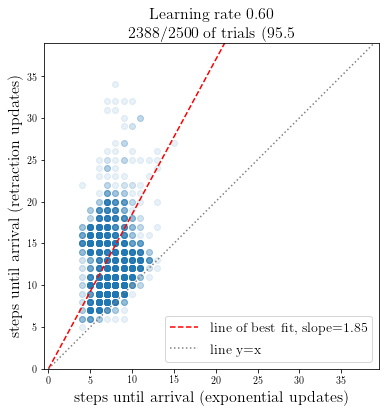

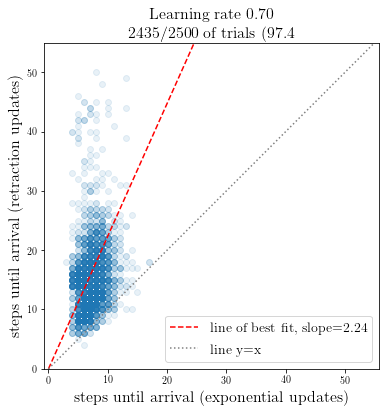

In [14]:
from sklearn.decomposition import PCA

def slope_of_best_fitting_line(pts):
    """
    Return the slope of the best fitting line through the origin
    i.e. minimising the sum of the squared distances to the line
    (a.k.a. "linear orthogonal regression")
    """
    model = PCA(n_components=1)
    model.fit(pts)
    component = model.mean_ + model.components_[0,:]
    return component[1] / component[0]

def plot_scatterplot(lr):
    optimisations_lr_filtered = [optim for optim in optimisations if optim.lr.round(5) == lr]
    optimisation_pairs = pair_optimisations(optimisations_lr_filtered)
    stas = [[optim.get_number_updates() for optim in pair] for pair in optimisation_pairs]
    pts = np.array(stas)
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    lims = (0, pts.max() + 5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    font_args = dict(fontsize=16, fontname='Times New Roman')
    ax.set_xlabel('steps until arrival (exponential updates)', **font_args)
    ax.set_ylabel('steps until arrival (retraction updates)', **font_args)
    ax.scatter(pts[:,0], pts[:,1], alpha=0.1)
    ax.set_aspect('equal', 'datalim')
    
    # plot the line of best fit
    slope = slope_of_best_fitting_line(pts)
    xs = np.linspace(0, 2 * pts.max(), 100)
    ys = [slope*x for x in xs]
    ax.plot(xs, ys, linestyle='--', c='r', label='line of best fit, slope=%.2f' % slope)

    # plot the line y=x
    #plt.grid()
    ax.plot(xs, xs, linestyle=':', c='gray', label='line y=x')
    
    wins = (pts[:,0] < pts[:,1]).sum()
    win_rate = wins / len(pts)
    ax.set_title('Learning rate %.2f\n%i/%i of trials (%.1f%%) strictly above y=x' % (lr, wins, len(pts), win_rate * 100), **font_args)
    plt.legend(fontsize=14)
    return fig, ax

for lr in [0.6, 0.7]:
    fig, ax = plot_scatterplot(lr)
    lr_as_str = ('%.2f' % lr).replace('.', '')
    plt.savefig('/Users/benjaminwilson/optimisation-on-the-hyperboloid/scatterplot_lr%s.pdf' % lr_as_str,
                bbox_inches='tight',
                format='pdf')
    plt.show()